<h1><b><center>Movie Rating Prediction</b></h1>

## Project Overview
In this project, we aimed to understand how different factors contribute to a movie's success, particularly its rating, and predict the ratings of movies based on a variety of features including release year, duration, genre, number of votes, etc. using machine learning techniques.

Objective - The goal is to analyze historical movie data and develop a model that accurately estimates the rating given to a movie by users or critics. We will explore data cleaning, data analysis, data preprocessing, feature engineering, and machine learning modeling techniques.

### About the Dataset: 
This dataset is pulled from IMDb.com of all the Indian movies on the platform. It contains multiple columns related to movies with their IMDB rating.

#### Columns in our dataset
1. <b>Name</b> - Name of the movie
2. <b>Year</b> - Year of movie release
3. <b>Duration</b> - Duration of the movie in minutes
4. <b>Genre</b> - Genre(s) of the movie
5. <b>Rating</b> - IMDB rating of the movie (Target Variable)
6. <b>Votes</b> - Number of votes
7. <b>Director</b> - Director of the movie
8. <b>Actor 1</b> - Lead actor of the movie
9. <b>Actor 2</b> - Second actor of the movie
10. <b>Actor 3</b> - Third actor of the movie



In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
%matplotlib inline

# Suppressing warnings
import warnings
warnings.filterwarnings('ignore')




In [2]:
# Loading the dataset
data = pd.read_csv('Movie dataset.csv', encoding='ISO-8859-1')



## Basic Data Exploration and Cleaning

In [3]:
# Checking how the data looks like
data.head()



,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


In [4]:
# Checking the shape of the data
data.shape



(15509, 10)

In [5]:
# Let's look for duplicate rows
data.duplicated().sum()



6

There are 6 duplicate rows. Let's delete them.


In [6]:
# Dropping the duplicate rows
data = data.drop_duplicates()



In [7]:
# Checking the datatypes and non null count
data.info()



<class 'pandas.core.frame.DataFrame'>
Index: 15503 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15503 non-null  object 
 1   Year      14976 non-null  object 
 2   Duration  7239 non-null   object 
 3   Genre     13627 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14979 non-null  object 
 7   Actor 1   13888 non-null  object 
 8   Actor 2   13122 non-null  object 
 9   Actor 3   12363 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.3+ MB


We can see that we have some null values in our dataset which we will impute later.

Let's drop the 'Name' column first as it won't be helpful in the prediction of movie ratings.

In [8]:
data.drop(columns=['Name'], inplace=True)



In [9]:
# Looking for total missing values in each column
data.isna().sum()



Year         527
Duration    8264
Genre       1876
Rating      7584
Votes       7583
Director     524
Actor 1     1615
Actor 2     2381
Actor 3     3140
dtype: int64

The dependent variable 'Rating' has some missing values which is a problem.

Let's see if there is any relation between these missing values

In [10]:
# Percentage of missing values where rating is missing
data[data['Rating'].isna()].isna().mean()*100



Year          6.948840
Duration     81.698312
Genre        23.391350
Rating      100.000000
Votes        99.986814
Director      6.843354
Actor 1      19.646624
Actor 2      28.757911
Actor 3      37.552743
dtype: float64

Almost all values in 'Rating' and 'Votes' are null in the same rows.

Also, 80% of 'Duration' is missing for these rows.

We can drop these rows as they won't be helping much in training the model

In [11]:
# Dropping the rows with missing rating
data = data.dropna(subset='Rating')

# Resetting the index
data.reset_index(inplace=True, drop=True)



In [12]:
data.head()



,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
1,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
2,(1997),147 min,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
3,(2005),142 min,"Drama, Romance, War",7.4,"1,086",Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma
4,(2012),82 min,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia


Columns 'Year', 'Duration', and 'Votes' need formatting.

Let's format these.

In [13]:
# Removing parentheses from years
data['Year'] = data['Year'].apply(lambda x: int(x[1:-1]))



In [14]:
# Extracting number from the duration string
data['Duration'][~data['Duration'].isna()] = data['Duration'][~data['Duration'].isna()].apply(lambda x: x.split()[0])

# Changing the datatype of 'Duration' column from object to numerical
data['Duration'] = pd.to_numeric(data['Duration'], errors='coerce', downcast='integer')



In [15]:
# Removing comma from 'Votes' column
data['Votes'] = data['Votes'].apply(lambda x: int(x.replace(',', '')))



In [16]:
# Let's see how our data looks like now
data.head()



,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,2019,109.0,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
1,2019,110.0,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
2,1997,147.0,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
3,2005,142.0,"Drama, Romance, War",7.4,1086,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma
4,2012,82.0,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia


In [17]:
# Checking the datatypes
data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7919 entries, 0 to 7918
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      7919 non-null   int64  
 1   Duration  5851 non-null   float64
 2   Genre     7817 non-null   object 
 3   Rating    7919 non-null   float64
 4   Votes     7919 non-null   int64  
 5   Director  7914 non-null   object 
 6   Actor 1   7794 non-null   object 
 7   Actor 2   7719 non-null   object 
 8   Actor 3   7627 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 556.9+ KB


There are still some missing values which we will deal with later.

First let's perform some EDA and look for some patterns.

## Exploratory Data Analysis

In [18]:
# Basic statistical summary of numerical columns
data.describe()



,Year,Duration,Rating,Votes
count,7919.000000,5851.000000,7919.000000,7919.000000
mean,1993.321758,132.294480,5.841621,1938.520394
std,20.463770,26.555826,1.381777,11602.415952
min,1917.000000,21.000000,1.100000,5.000000
25%,1979.500000,117.000000,4.900000,16.000000
50%,1997.000000,134.000000,6.000000,55.000000
75%,2011.000000,150.000000,6.800000,404.000000
max,2021.000000,321.000000,10.000000,591417.000000


- The minimum rating is 1.1 and the maximum rating is 10. The median rating is 6.0
- 75% of values in the votes column are below 404 and the maximum votes are 591417, which suggests that the distribution is right skewed and may have outliers.
- 50% of movies have a duration between 117 and 150 minutes.

In [19]:
# Basic statistical summary of categorical columns
data.describe(include='object')



,Genre,Director,Actor 1,Actor 2,Actor 3
count,7817,7914,7794,7719,7627
unique,432,3139,2551,2873,3064
top,Drama,Mahesh Bhatt,Jeetendra,Rekha,Pran
freq,1177,47,140,79,75


- There are 432 unique genres and Drama is the most popular one.
- Directors and actors have many unique values.
- Most popular director is Mahesh Bhatt and the most popular actors are Jeetendra, Rekha, and Pran.

In [20]:
# Let's see if there is any correlation between the columns
data.corr(numeric_only=True)



,Year,Duration,Rating,Votes
Year,1.000000,-0.337425,-0.166673,0.129016
Duration,-0.337425,1.000000,-0.031093,0.099660
Rating,-0.166673,-0.031093,1.000000,0.126635
Votes,0.129016,0.099660,0.126635,1.000000


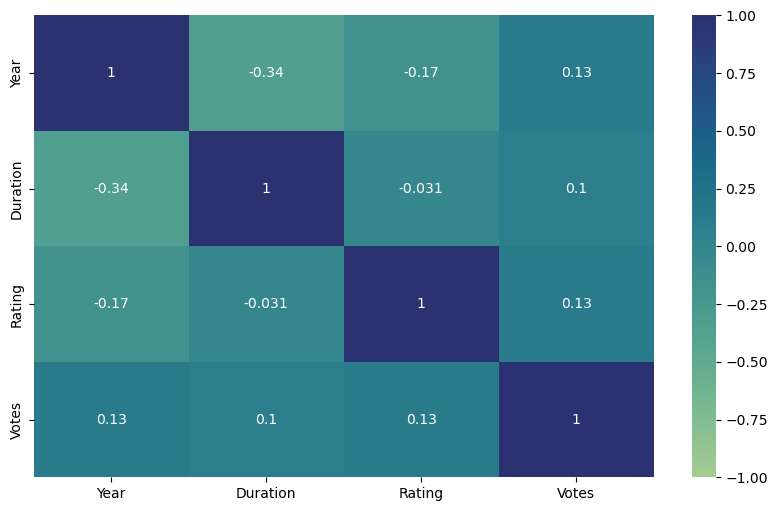

In [21]:
# Let's visualize the correlation using seaborn
plt.figure(figsize=(10,6))
sns.heatmap(data.corr(numeric_only=True), vmin=-1.0, annot=True, cmap='crest')
plt.show()



- Duration is slightly negatively correlated with Year. This means newer movies are shorter
- Rating is very slightly positively correlated with Votes and slightly negatively correlated with Year. This means newer movies or movies with more votes get slightly higher ratings.

#### Rating

Skewness = -0.35


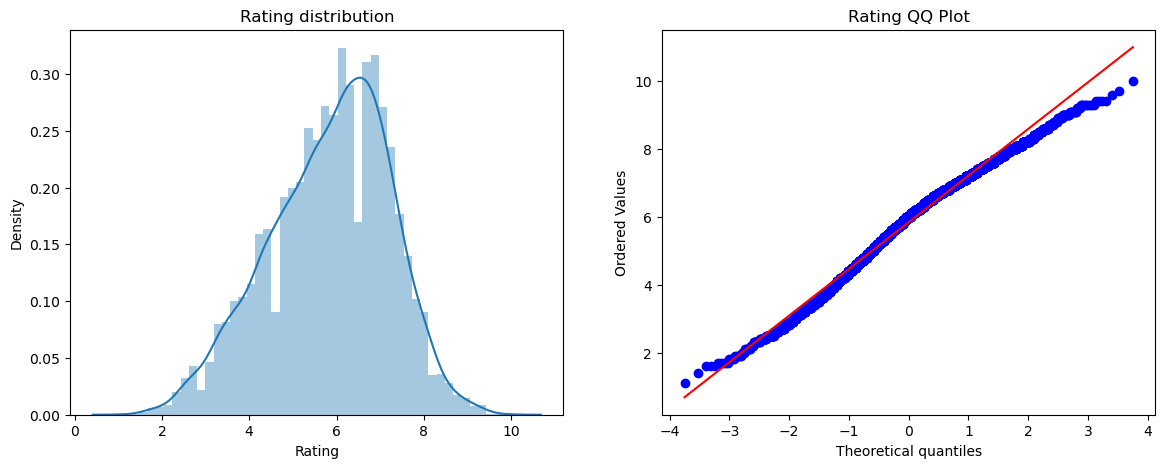

In [22]:
# Checking the skewness
print("Skewness =", round(data['Rating'].skew(), 2))

# Plotting ratings histogram
plt.figure(figsize=(14,5))
plt.subplot(121)
sns.distplot(data['Rating'])
plt.title('Rating distribution')

# Plotting QQ Plot of ratings
plt.subplot(122)
stats.probplot(data['Rating'], plot=plt)
plt.title('Rating QQ Plot')
plt.show()



Rating is slightly negatively skewed.

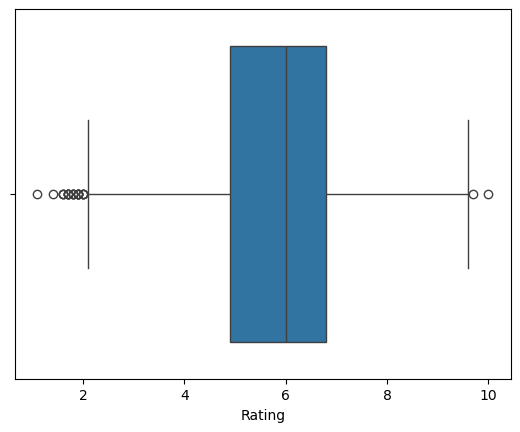

In [23]:
# Plotting a boxplot to check for outliers
sns.boxplot(data=data, x='Rating')
plt.show()



- There are a few outliers, especially in the lower rating section.

#### Year

Skewness = -0.65


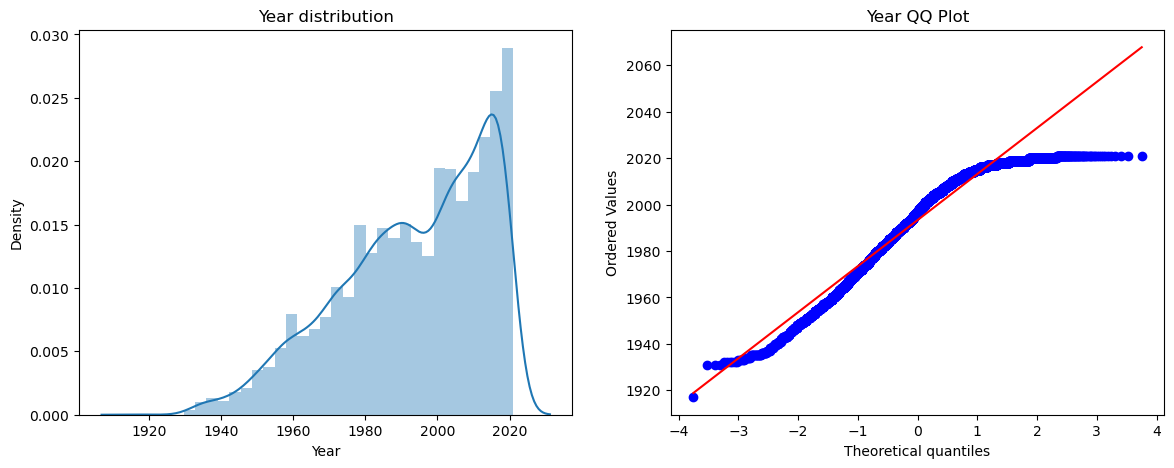

In [24]:
# Checking the skewness
print("Skewness =", round(data['Year'].skew(), 2))

# Plotting years histogram
plt.figure(figsize=(14,5))
plt.subplot(121)
sns.distplot(data['Year'])
plt.title('Year distribution')

# Plotting QQ Plot of years
plt.subplot(122)
stats.probplot(data['Year'], plot=plt)
plt.title('Year QQ Plot')
plt.show()




The year column is negatively skewed.

Which means most of the movies are from recent years.

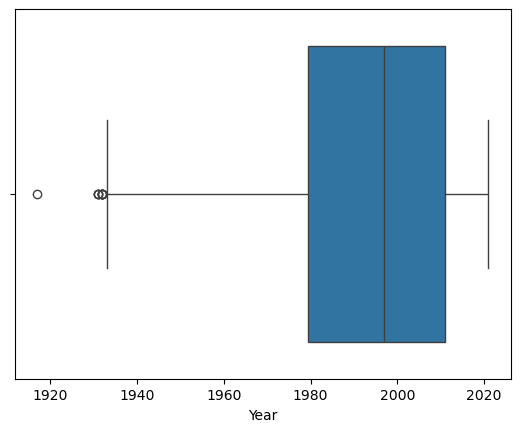

In [25]:
# Plotting a boxplot to check for outliers
sns.boxplot(data=data, x='Year')
plt.show()



- There are a few outliers in the lower end of the boxplot.

#### Duration

Skewness = -0.11


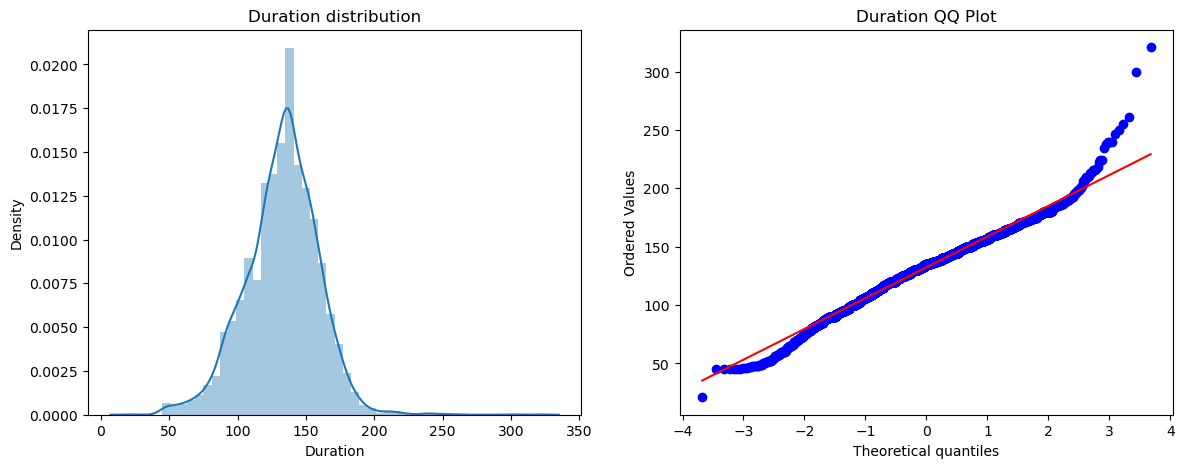

In [26]:
# Checking the skewness
print("Skewness =", round(data['Duration'].skew(), 2))

# Plotting durations histogram
plt.figure(figsize=(14,5))
plt.subplot(121)
sns.distplot(data['Duration'])
plt.title('Duration distribution')


# Plotting QQ Plot of durations
plt.subplot(122)
stats.probplot(data['Duration'][~data['Duration'].isna()], plot=plt)
plt.title('Duration QQ Plot')
plt.show()






Duration seems to have a positive kurtosis.



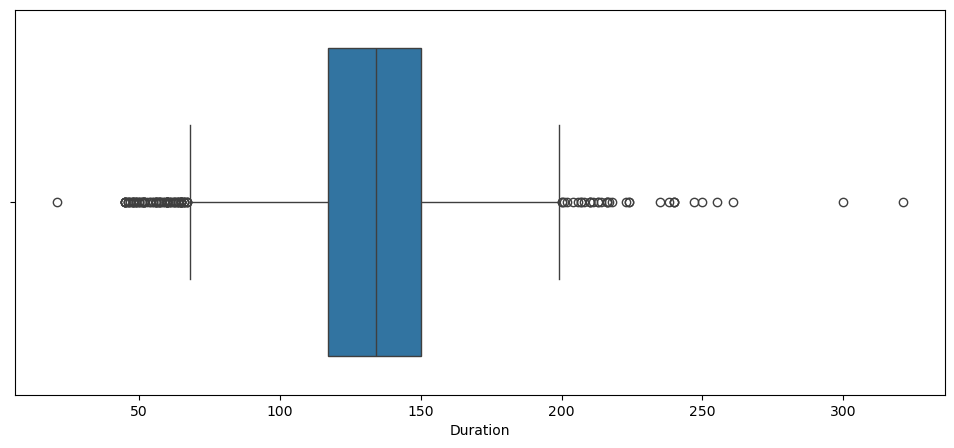

In [27]:
# Plotting a boxplot to check for outliers
plt.figure(figsize=(12,5))
sns.boxplot(data=data, x='Duration')
plt.show()



- There are outliers present on both ends of the boxplot.



#### Votes

Skewness = 25.39


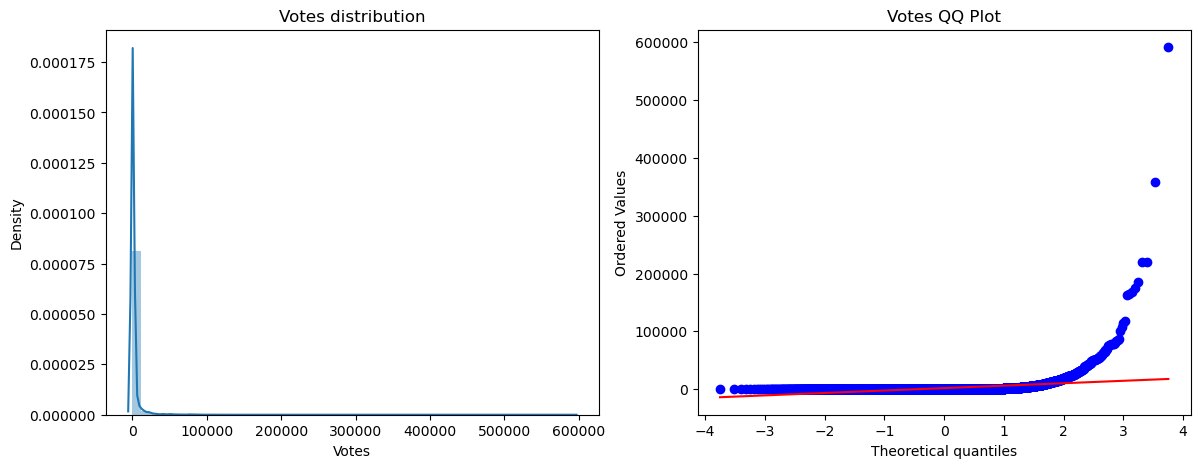

In [28]:
# checking the skewness
print("Skewness =", round(data['Votes'].skew(), 2))

# Plotting votes histogram
plt.figure(figsize=(14,5))
plt.subplot(121)
sns.distplot(data['Votes'])
plt.title('Votes distribution')

# Plotting QQ Plot of votes
plt.subplot(122)
stats.probplot(data['Votes'], plot=plt)
plt.title('Votes QQ Plot')
plt.show()




The Votes column is extremely positively skewed

This can be a problem with a few models. We will transform this column later.

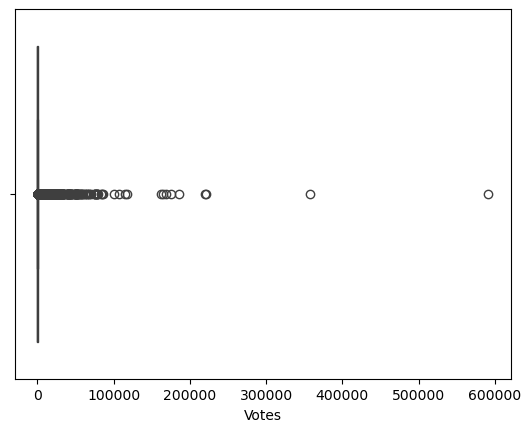

In [29]:
# Plotting a boxplot to check for outliers
sns.boxplot(data=data, x='Votes')
plt.show()



- There are many outliers in the higher end.

#### Relation between numerical columns

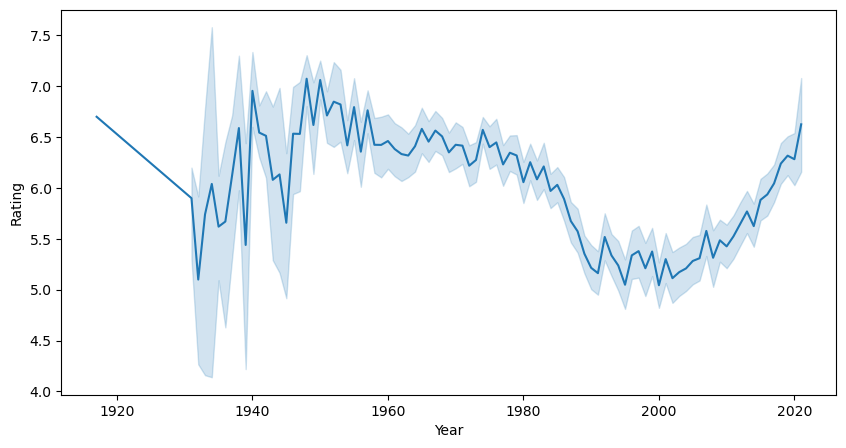

In [30]:
# Let's plot the change in ratings with respect to years
plt.figure(figsize=(10,5))
sns.lineplot(data, x='Year', y='Rating')
plt.show()



The ratings slightly dipped around 1990-2010, but they have been increasing in recent years.



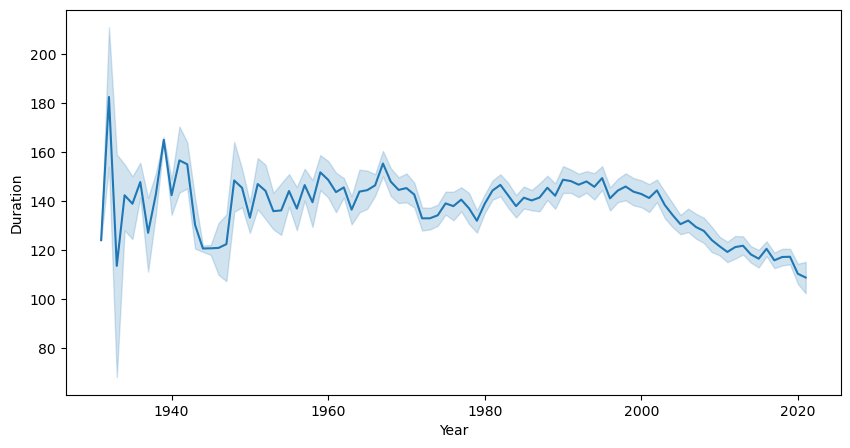

In [31]:
# Let's plot the change in duration with respect to years
plt.figure(figsize=(10,5))
sns.lineplot(data, x='Year', y='Duration')
plt.show()



The duration of movies has been slightly decreasing in recent years.



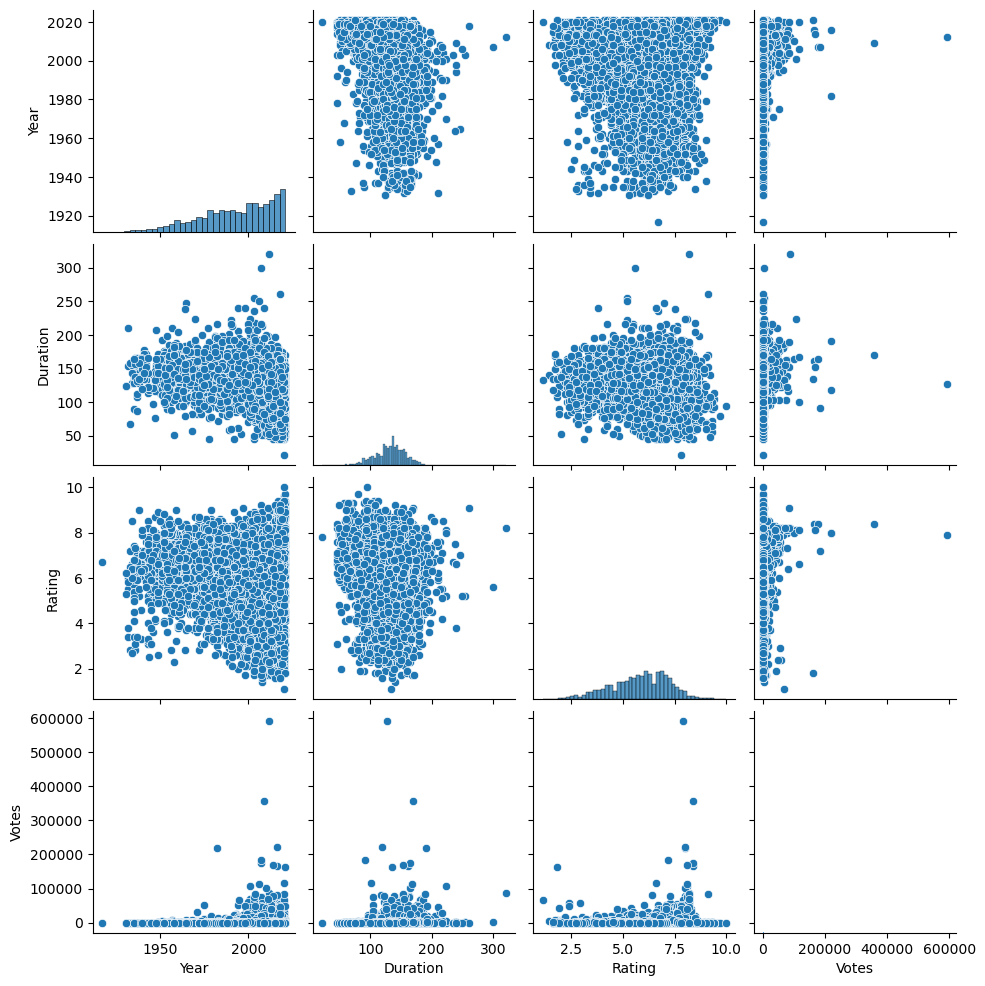

In [32]:
# Let's plot a pairplot of the columns in the dataset to look for any relation
sns.pairplot(data)
plt.show()



#### Analyzing categorical columns

##### 1. Genre

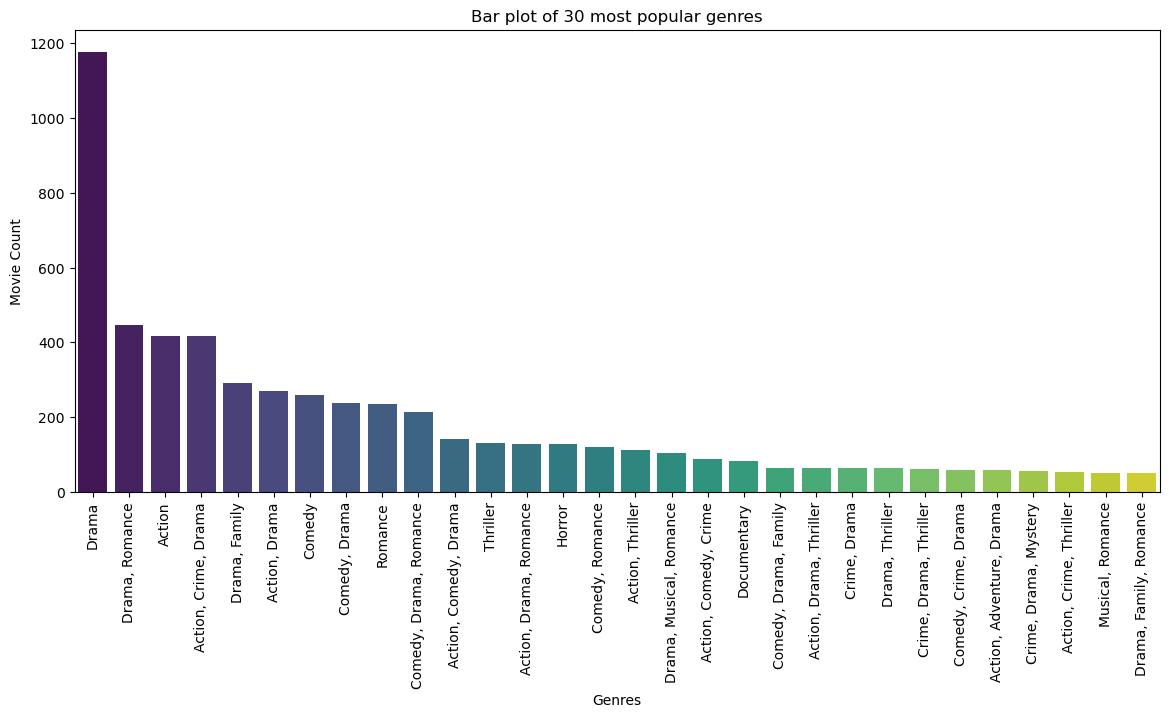

In [33]:
# Checking the most popular genres using a boxplot
plt.figure(figsize=(14, 6))
sns.barplot(data.groupby('Genre').count().sort_values('Rating', ascending=False).head(30)['Rating'], palette='viridis')
plt.title('Bar plot of 30 most popular genres')
plt.ylabel('Movie Count')
plt.xlabel('Genres')
plt.xticks(rotation=90)
plt.show()



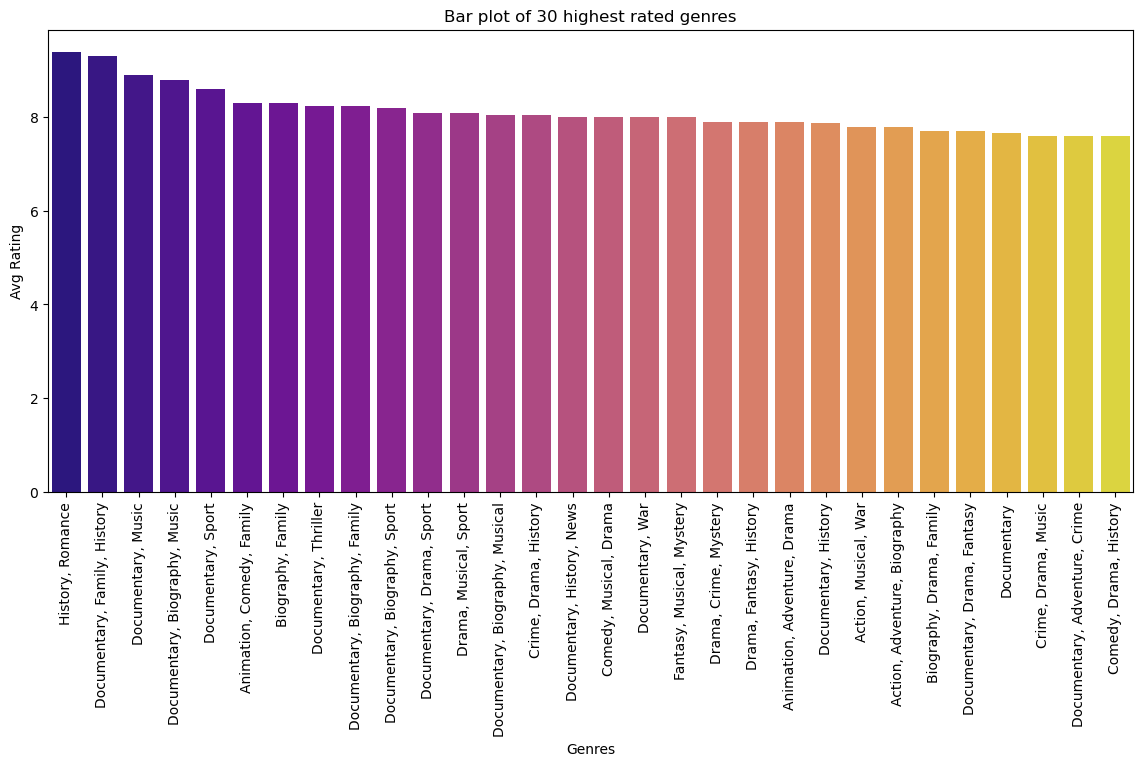

In [34]:
# Checking the highest rated genres using a boxplot
plt.figure(figsize=(14, 6))
sns.barplot(data.groupby('Genre')['Rating'].mean().sort_values(ascending=False).head(30), palette='plasma')
plt.title('Bar plot of 30 highest rated genres')
plt.ylabel('Avg Rating')
plt.xlabel('Genres')
plt.xticks(rotation=90)
plt.show()



##### 2. Director

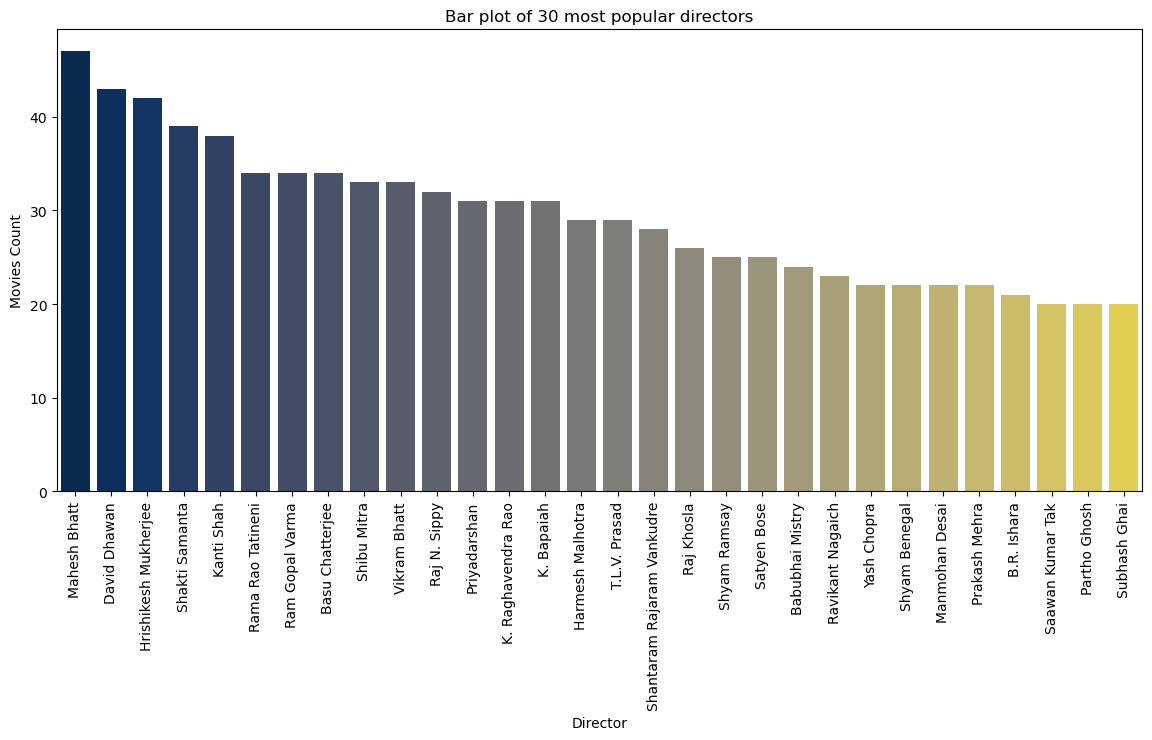

In [35]:
# Checking the most popular directors using a boxplot
plt.figure(figsize=(14, 6))
sns.barplot(data.groupby('Director').count().sort_values('Rating', ascending=False).head(30)['Rating'], palette='cividis')
plt.title('Bar plot of 30 most popular directors')
plt.ylabel('Movies Count')
plt.xlabel('Director')
plt.xticks(rotation=90)
plt.show()



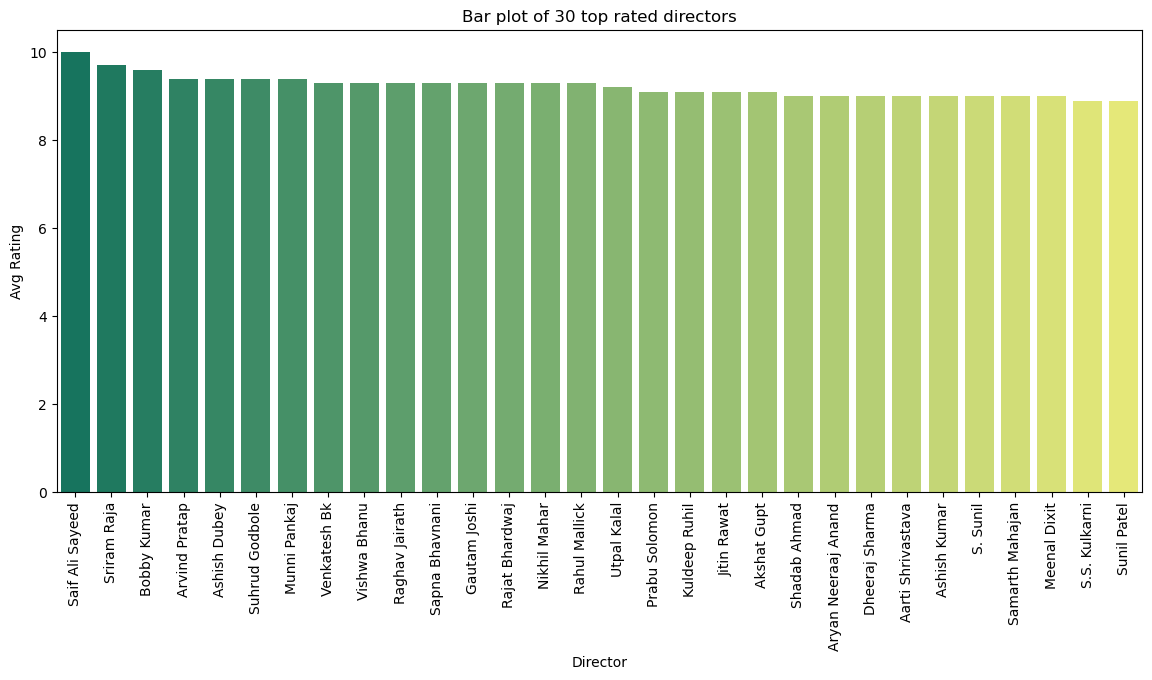

In [36]:
# Checking the top rated directors using a boxplot
plt.figure(figsize=(14, 6))
sns.barplot(data.groupby('Director')['Rating'].mean().sort_values(ascending=False).head(30), palette='summer')
plt.title('Bar plot of 30 top rated directors')
plt.ylabel('Avg Rating')
plt.xlabel('Director')
plt.xticks(rotation=90)
plt.show()



##### 3. Actor 1

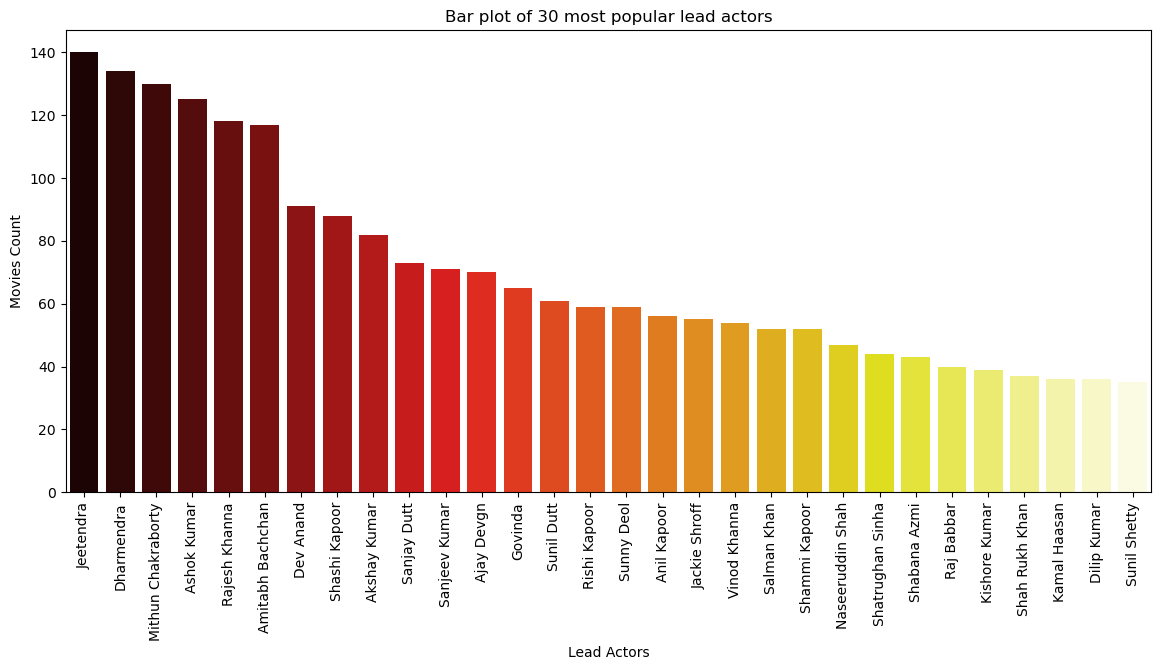

In [37]:
# Checking the most popular lead actors using a boxplot
plt.figure(figsize=(14, 6))
sns.barplot(data.groupby('Actor 1').count().sort_values('Rating', ascending=False).head(30)['Rating'], palette='hot')
plt.title('Bar plot of 30 most popular lead actors')
plt.ylabel('Movies Count')
plt.xlabel('Lead Actors')
plt.xticks(rotation=90)
plt.show()



##### 4. Actor 2

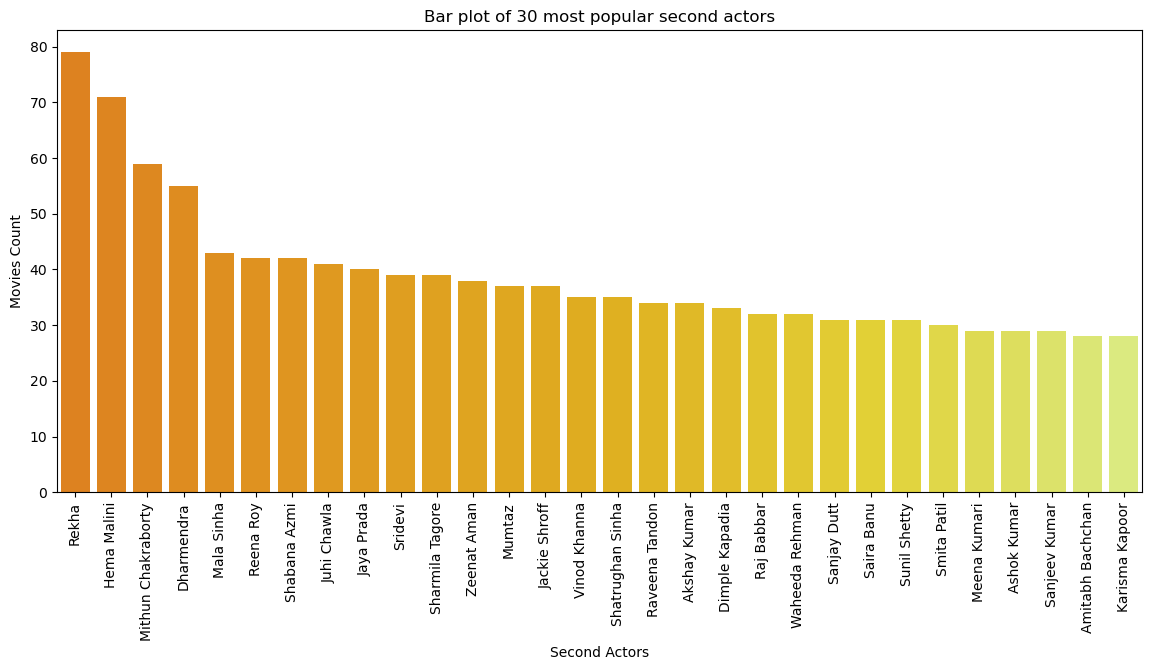

In [38]:
# Checking the most popular second actors using a boxplot
plt.figure(figsize=(14, 6))
sns.barplot(data.groupby('Actor 2').count().sort_values('Rating', ascending=False).head(30)['Rating'], palette='Wistia_r')
plt.title('Bar plot of 30 most popular second actors')
plt.ylabel('Movies Count')
plt.xlabel('Second Actors')
plt.xticks(rotation=90)
plt.show()



##### 5. Actor 3

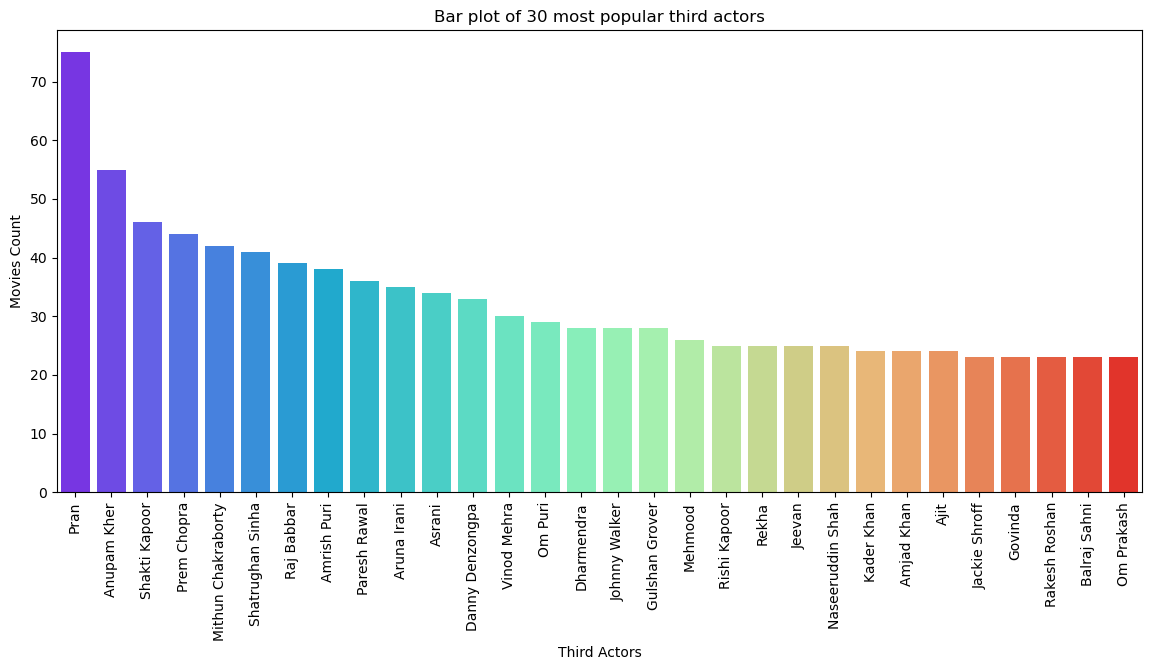

In [39]:
# Checking the most popular third actors using a boxplot
plt.figure(figsize=(14, 6))
sns.barplot(data.groupby('Actor 3').count().sort_values('Rating', ascending=False).head(30)['Rating'], palette='rainbow')
plt.title('Bar plot of 30 most popular third actors')
plt.ylabel('Movies Count')
plt.xlabel('Third Actors')
plt.xticks(rotation=90)
plt.show()



## Data Preprocessing and Feature Engineering

In [40]:
# Checking for missing values
data.isna().sum()



Year           0
Duration    2068
Genre        102
Rating         0
Votes          0
Director       5
Actor 1      125
Actor 2      200
Actor 3      292
dtype: int64

There are many missing values in categorical columns.

Let's impute them using the most frequent value (mode) in that column.

In [41]:
# Imputing the categorical columns using mode
data['Genre'] = data['Genre'].fillna(data['Genre'].mode()[0])
data['Director'] = data['Director'].fillna(data['Director'].mode()[0])
data['Actor 1'] = data['Actor 1'].fillna(data['Actor 1'].mode()[0])
data['Actor 2'] = data['Actor 2'].fillna(data['Actor 2'].mode()[0])
data['Actor 3'] = data['Actor 3'].fillna(data['Actor 3'].mode()[0])



In [42]:
# Let's see how our data looks like now
data.head()



,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,2019,109.0,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
1,2019,110.0,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
2,1997,147.0,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
3,2005,142.0,"Drama, Romance, War",7.4,1086,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma
4,2012,82.0,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia


There are many unique values in Director, Actor 1, Actor 2, and Actor 3 columns.

One hot encoding these many columns will be impractical.

So let's frequency encode these columns instead. The resulting columns will work as a popularity measure for them.

In [43]:
# Frequency encoding the columns
data['Director_Frequency'] = data['Director'].map(data['Director'].value_counts())
data['Actor1_Frequency'] = data['Actor 1'].map(data['Actor 1'].value_counts())
data['Actor2_Frequency'] = data['Actor 2'].map(data['Actor 2'].value_counts())
data['Actor3_Frequency'] = data['Actor 3'].map(data['Actor 3'].value_counts())



In [44]:
# Dropping the columns
data.drop(columns=['Director', 'Actor 1', 'Actor 2', 'Actor 3'], inplace=True)

data.head()



,Year,Duration,Genre,Rating,Votes,Director_Frequency,Actor1_Frequency,Actor2_Frequency,Actor3_Frequency
0,2019,109.0,Drama,7.0,8,1,2,1,1
1,2019,110.0,"Comedy, Romance",4.4,35,1,5,1,2
2,1997,147.0,"Comedy, Drama, Musical",4.7,827,17,18,15,13
3,2005,142.0,"Drama, Romance, War",7.4,1086,7,25,4,8
4,2012,82.0,"Horror, Mystery, Thriller",5.6,326,1,1,6,1


<font color=#00FF00>Note: We can also use target mean encoding, but that will cause overfitting, target leakage, and inflated performance metrics during training.</font>

<font color=#00FF00>Also, it'll make working with new categories difficult.</font>


Let's look at the genre column now.

In [45]:
data['Genre'].nunique()

432

The Genre column contains many unique values.

However, we can see that the values are combinations of a few genres separated by commas.

Let's see how many actual unique genres are there.

In [46]:
# function that returns a list of genres in a row
def genre_list(x):
    genres = []
    for i in x.split(','):
        genres.append(i.strip())
    return genres

# Applying the function on the Genre column
data['Genre'] = data['Genre'].apply(genre_list)

# This is how the Genre column looks now
data.head()



,Year,Duration,Genre,Rating,Votes,Director_Frequency,Actor1_Frequency,Actor2_Frequency,Actor3_Frequency
0,2019,109.0,[Drama],7.0,8,1,2,1,1
1,2019,110.0,"[Comedy, Romance]",4.4,35,1,5,1,2
2,1997,147.0,"[Comedy, Drama, Musical]",4.7,827,17,18,15,13
3,2005,142.0,"[Drama, Romance, War]",7.4,1086,7,25,4,8
4,2012,82.0,"[Horror, Mystery, Thriller]",5.6,326,1,1,6,1


In [47]:
# Let's get a set of unique genres
unique_genres = set()
for genre in data['Genre']:
    for g in genre:
        unique_genres.add(g)

print(unique_genres)



{'Biography', 'Western', 'Musical', 'News', 'Sci-Fi', 'Music', 'War', 'Animation', 'Horror', 'Crime', 'Comedy', 'Adventure', 'Documentary', 'Drama', 'Thriller', 'Family', 'Mystery', 'Romance', 'Action', 'Fantasy', 'Sport', 'History'}


We have 22 unique genres.

We can apply manual one-hot encoding on these.


let's add a column in the dataframe for each unique genre.

In [48]:
# One-hot encoding each unique genre
for genre in unique_genres:
    data[f'Genre_{genre}'] = data['Genre'].apply(lambda x: 1 if genre in x else 0)

# Dropping the Genre column
data.drop('Genre', axis=1, inplace=True)

# This is how our data looks now
data.head()



,Year,Duration,Rating,Votes,Director_Frequency,Actor1_Frequency,Actor2_Frequency,Actor3_Frequency,Genre_Biography,Genre_Western,...,Genre_Documentary,Genre_Drama,Genre_Thriller,Genre_Family,Genre_Mystery,Genre_Romance,Genre_Action,Genre_Fantasy,Genre_Sport,Genre_History
0,2019,109.0,7.0,8,1,2,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,2019,110.0,4.4,35,1,5,1,2,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1997,147.0,4.7,827,17,18,15,13,0,0,...,0,1,0,0,0,0,0,0,0,0
3,2005,142.0,7.4,1086,7,25,4,8,0,0,...,0,1,0,0,0,1,0,0,0,0
4,2012,82.0,5.6,326,1,1,6,1,0,0,...,0,0,1,0,1,0,0,0,0,0


Let's split the data into train and test sets.

In [49]:
# Splitting the data into independent and dependent variables
X = data.drop('Rating', axis=1)
y = data['Rating']


# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)




#### Imputing Missing Duration

In [50]:
# Checking missing values
X_train.isna().sum()



Year                     0
Duration              1646
Votes                    0
Director_Frequency       0
Actor1_Frequency         0
Actor2_Frequency         0
Actor3_Frequency         0
Genre_Biography          0
Genre_Western            0
Genre_Musical            0
Genre_News               0
Genre_Sci-Fi             0
Genre_Music              0
Genre_War                0
Genre_Animation          0
Genre_Horror             0
Genre_Crime              0
Genre_Comedy             0
Genre_Adventure          0
Genre_Documentary        0
Genre_Drama              0
Genre_Thriller           0
Genre_Family             0
Genre_Mystery            0
Genre_Romance            0
Genre_Action             0
Genre_Fantasy            0
Genre_Sport              0
Genre_History            0
dtype: int64

There are missing values in the Duration column.

Let's see the impact of different imputing methods.

Variance before imputation: 705.211899434243
Variance after imputation: 520.0713082496685


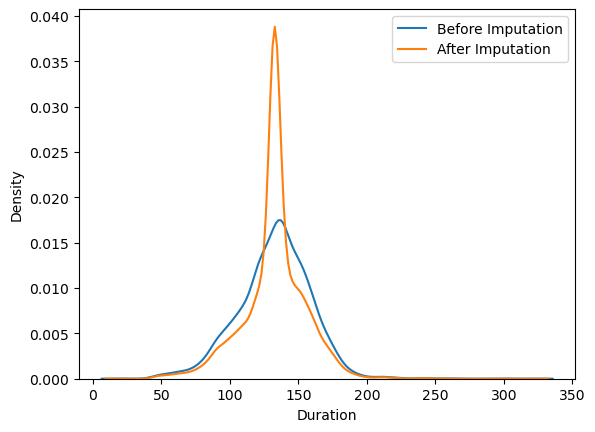

In [51]:
# Variance change if we impute with mean
print('Variance before imputation:', data['Duration'].var())
print('Variance after imputation:', X_train['Duration'].fillna(X_train['Duration'].mean()).var())


# Distribution change if we impute with mean
plt.figure()
sns.distplot(X_train['Duration'], hist=False, label='Before Imputation')
sns.distplot(X_train['Duration'].fillna(X_train['Duration'].mean()), hist=False, label='After Imputation')
plt.legend()
plt.show()



Variance before imputation: 705.211899434243
Variance after imputation: 521.2204403192263


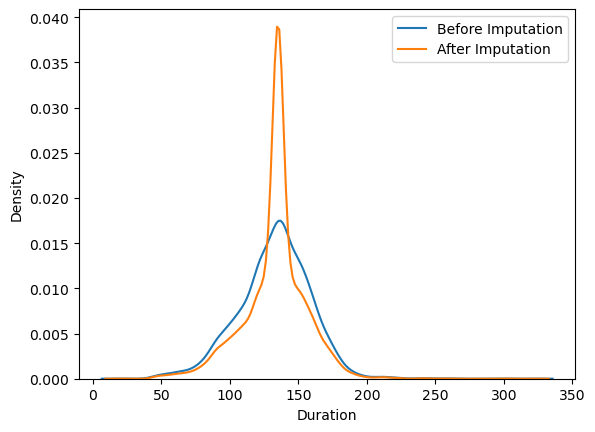

In [52]:
# Variance change if we impute with median
print('Variance before imputation:', data['Duration'].var())
print('Variance after imputation:', X_train['Duration'].fillna(X_train['Duration'].median()).var())


# Distribution change if we impute with median
plt.figure()
sns.distplot(X_train['Duration'], hist=False, label='Before Imputation')
sns.distplot(X_train['Duration'].fillna(X_train['Duration'].median()), hist=False, label='After Imputation')
plt.legend()
plt.show()



Imputing missing values with mean or median is drastically changing our distribution.

Let's try IterativeImputer to fill these missing values

In [53]:
ii = IterativeImputer(RandomForestRegressor(n_jobs=-1, random_state=0), max_iter=10)
ii_duration_train = ii.fit_transform(X_train)
ii_duration_test = ii.transform(X_test)



Variance before imputation: 705.211899434243
Variance after imputation: 568.9672326582067


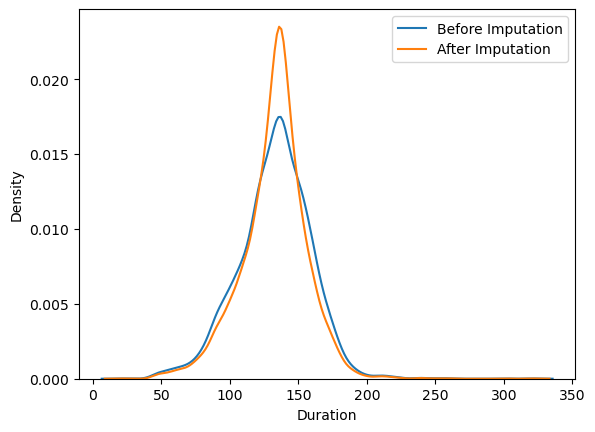

In [54]:
# Variance change if we impute with IterativeImputer
print('Variance before imputation:', data['Duration'].var())
print('Variance after imputation:', ii_duration_train[:, 1].var())


# Distribution change if we impute with IterativeImputer
plt.figure()
sns.distplot(X_train['Duration'], hist=False, label='Before Imputation')
sns.distplot(ii_duration_train[:, 1], hist=False, label='After Imputation')
plt.legend()
plt.show()



It performs much better than simply imputing the values with mean or median.

Let's go ahead with this imputation method.

In [55]:
X_train['Duration'] = ii_duration_train[:,1]
X_test['Duration'] = ii_duration_test[:,1]



In [56]:
# This is how our data looks now
X_train.tail()



,Year,Duration,Votes,Director_Frequency,Actor1_Frequency,Actor2_Frequency,Actor3_Frequency,Genre_Biography,Genre_Western,Genre_Musical,...,Genre_Documentary,Genre_Drama,Genre_Thriller,Genre_Family,Genre_Mystery,Genre_Romance,Genre_Action,Genre_Fantasy,Genre_Sport,Genre_History
4931,1975,114.00,5,5,20,31,22,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3264,1970,151.34,48,8,4,55,7,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1653,2010,145.00,355,19,2,6,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2607,1992,151.00,56,20,7,8,11,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2732,2015,114.00,533,16,14,8,7,1,0,0,...,0,1,0,0,0,0,0,0,0,0


#### Feature Transformation

Skewness = 28.66


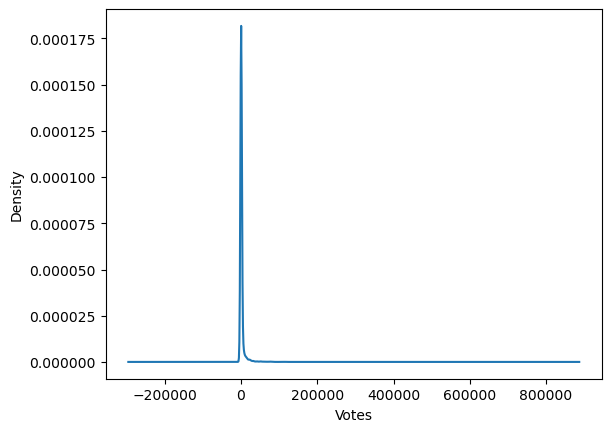

In [57]:
# Let's see the distribution of the Votes column
print("Skewness =", round(X_train['Votes'].skew(), 2))
X_train['Votes'].plot(kind='kde')
plt.xlabel('Votes')
plt.show()



Let's apply log transformation on this column to make it close to a normal distribution.



In [58]:
# Applying log transformation on Votes column
trf1 = FunctionTransformer(func=np.log)
X_train['Votes'] = trf1.fit_transform(X_train['Votes'])
X_test['Votes'] = trf1.transform(X_test['Votes'])



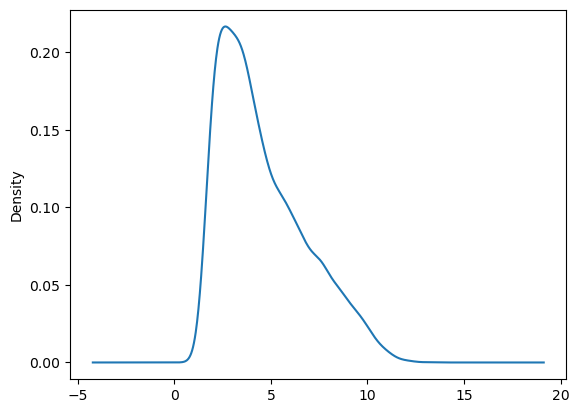

In [59]:
# Checking the distribution after transformation
X_train['Votes'].plot(kind='kde')
plt.show()



It's much better now.

#### Scaling the data

In [60]:
# Let's standardize the data using StandardScaler class from sklearn
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



## Model Building

In [61]:
# Creating a function that prints RMSE and R2 scores for both the train and test datasets. 
# This will help us check for model performance as well as overfitting.
def print_scores(model):
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)

    print("RMSE Train", round(mean_squared_error(y_train, y_pred_train, squared=False), 4))
    print("RMSE Test", round(mean_squared_error(y_test, y_pred_test, squared=False), 4))

    print("R2 Score Train", round(r2_score(y_train, y_pred_train), 4))
    print("R2 Score Test", round(r2_score(y_test, y_pred_test), 4))



### 1. Linear Regression

Ordinary least squares Linear Regression.



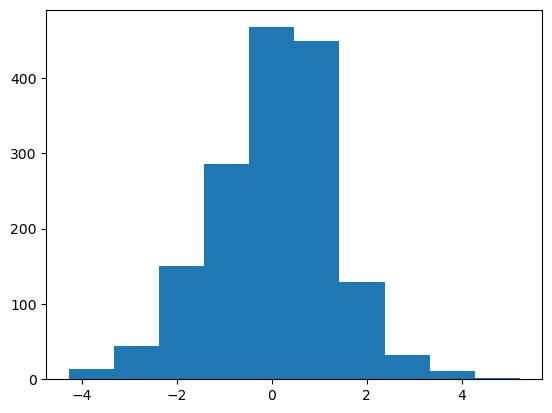

In [62]:
# Creating a model instance
lr = LinearRegression()
# Fitting the model on training data
lr.fit(X_train_scaled, y_train)

# Predicting on the test data
y_pred = lr.predict(X_test_scaled)

# Plotting the distribution of residuals
plt.figure()
residuals = y_test - y_pred
plt.hist(residuals)
plt.show()



In [63]:
# Printing the scores
print_scores(lr)



RMSE Train 1.2002
RMSE Test 1.2656
R2 Score Train 0.2345
R2 Score Test 0.2067


### 2. K-Nearest Neighbors Regressor

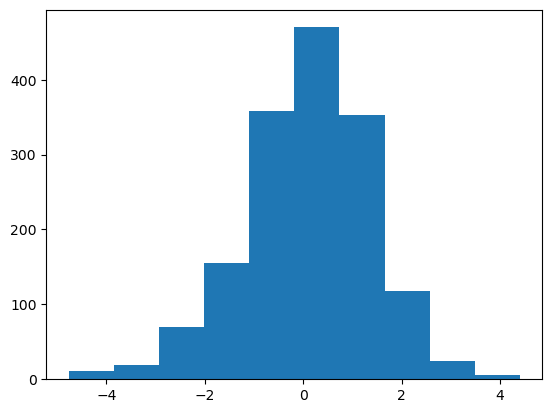

In [63]:
# Creating a model instance
knn = KNeighborsRegressor()
# Fitting the model on training data
knn.fit(X_train_scaled, y_train)

# Predicting on the test data
y_pred = knn.predict(X_test_scaled)

# Plotting the distribution of residuals
plt.figure()
residuals = y_test - y_pred
plt.hist(residuals)
plt.show()



In [64]:
# Printing the scores
print_scores(knn)



RMSE Train 0.9993
RMSE Test 1.2839
R2 Score Train 0.4693
R2 Score Test 0.1835


The model is slightly overfitting.

Let's perform hyperparameter tuning to see if it performs better.

In [65]:
# Tuning the hyperparameters using RandomizedSearchCV
param_grid = {'n_neighbors': range(2,8), 'weights' : ['uniform', 'distance'], 'p': [1,2]}
rs = RandomizedSearchCV(KNeighborsRegressor(), param_grid, n_iter=100, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
rs.fit(X_train_scaled, y_train)



Fitting 5 folds for each of 24 candidates, totalling 120 fits


RandomizedSearchCV(cv=5, estimator=KNeighborsRegressor(), n_iter=100, n_jobs=-1,
                   param_distributions={'n_neighbors': range(2, 8), 'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   scoring='neg_root_mean_squared_error', verbose=1)

In [66]:
print("Best parameters are:", rs.best_params_)
print("Best score is", round(-rs.best_score_, 4))



Best parameters are: {'weights': 'uniform', 'p': 1, 'n_neighbors': 7}
Best score is 1.1936


In [67]:
# Printing the scores after hyperparameter tuning
print_scores(rs)



RMSE Train 1.0336
RMSE Test 1.2589
R2 Score Train 0.4323
R2 Score Test 0.215


The performance has slightly improved.



In [68]:
# Assigning the best model from hyperparameter tuning
knn = rs.best_estimator_



### 3. SVM Regression

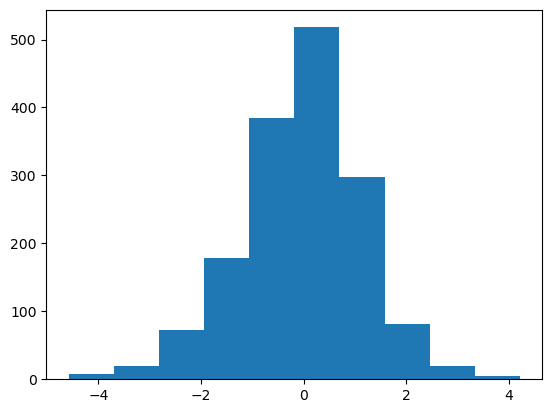

In [69]:
# Creating a model instance
svr = SVR()
# Fitting the model on training data
svr.fit(X_train_scaled, y_train)

# Predicting on the test data
y_pred = svr.predict(X_test_scaled)

# Plotting the distribution of residuals
plt.figure()
residuals = y_test - y_pred
plt.hist(residuals)
plt.show()



In [70]:
# Printing the scores
print_scores(svr)



RMSE Train 1.057
RMSE Test 1.1837
R2 Score Train 0.4062
R2 Score Test 0.306


Let's perform hyperparameter tuning to see if the model performs better.



In [71]:
# Tuning the hyperparameters using RandomizedSearchCV
param_grid = {'kernel': ['linear', 'rbf', 'sigmoid'], 'gamma': ['scale', 'auto'],
              'C': np.linspace(3, 3.5, 6), 'epsilon': np.linspace(0.5, 0.8, 4)}
rs = RandomizedSearchCV(SVR(), param_grid, n_iter=200, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
rs.fit(X_train_scaled, y_train)



Fitting 5 folds for each of 144 candidates, totalling 720 fits


RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=200, n_jobs=-1,
                   param_distributions={'C': array([3. , 3.1, 3.2, 3.3, 3.4, 3.5]),
                                        'epsilon': array([0.5, 0.6, 0.7, 0.8]),
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['linear', 'rbf', 'sigmoid']},
                   scoring='neg_root_mean_squared_error', verbose=1)

In [72]:
print("Best parameters are:", rs.best_params_)
print("Best score is", round(-rs.best_score_, 4))



Best parameters are: {'kernel': 'rbf', 'gamma': 'scale', 'epsilon': 0.7000000000000001, 'C': 3.5}
Best score is 1.1172


In [73]:
# Printing the scores after hyperparameter tuning
print_scores(rs)



RMSE Train 1.0122
RMSE Test 1.1775
R2 Score Train 0.4555
R2 Score Test 0.3132


The performance has improved but there is slight overfitting now too.



In [74]:
# Assigning the best model from hyperparameter tuning
svr = rs.best_estimator_



### 4. RandomForest Regressor

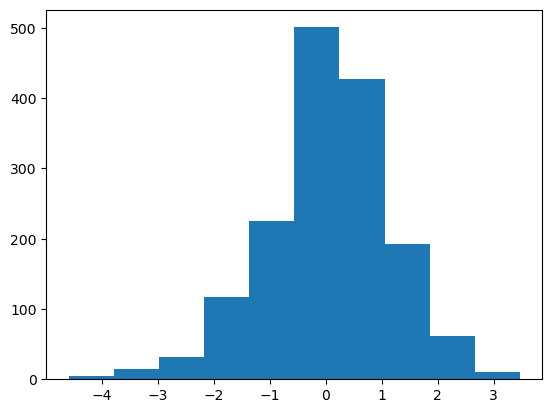

In [75]:
# Creating a model instance
rf = RandomForestRegressor()
# Fitting the model on training data
rf.fit(X_train_scaled, y_train)

# Predicting on the test data
y_pred = rf.predict(X_test_scaled)

# Plotting the distribution of residuals
plt.figure()
residuals = y_test - y_pred
plt.hist(residuals)
plt.show()



In [76]:
# Printing the scores
print_scores(rf)



RMSE Train 0.4054
RMSE Test 1.1083
R2 Score Train 0.9127
R2 Score Test 0.3915


The model is overfitting.

Let's perform hyperparameter tuning to see if it performs better.

In [77]:
# Tuning the hyperparameters using RandomizedSearchCV
param_grid = {'n_estimators' : range(100, 400, 100), 'max_depth' : range(5,16,2), "min_samples_leaf" : range(1,6,2),
              "min_samples_split" : range(2,10,2),
              "max_features" : np.linspace(0.2,0.8,7)}
rs = RandomizedSearchCV(RandomForestRegressor(), param_grid, n_iter=200, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1, random_state=0)
rs.fit(X_train_scaled, y_train)



Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=200,
                   n_jobs=-1,
                   param_distributions={'max_depth': range(5, 16, 2),
                                        'max_features': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'min_samples_leaf': range(1, 6, 2),
                                        'min_samples_split': range(2, 10, 2),
                                        'n_estimators': range(100, 400, 100)},
                   random_state=0, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [78]:
print("Best parameters are:", rs.best_params_)
print("Best score is", round(-rs.best_score_, 4))



Best parameters are: {'n_estimators': 200, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 0.6000000000000001, 'max_depth': 15}
Best score is 1.0799


In [79]:
# Printing the scores after hyperparameter tuning
print_scores(rs)



RMSE Train 0.731
RMSE Test 1.1004
R2 Score Train 0.716
R2 Score Test 0.4003


The performance has improved and the overfitting is reduced.



In [80]:
# Assigning the best model from hyperparameter tuning
rf = rs.best_estimator_



### 5. AdaBoost Regressor

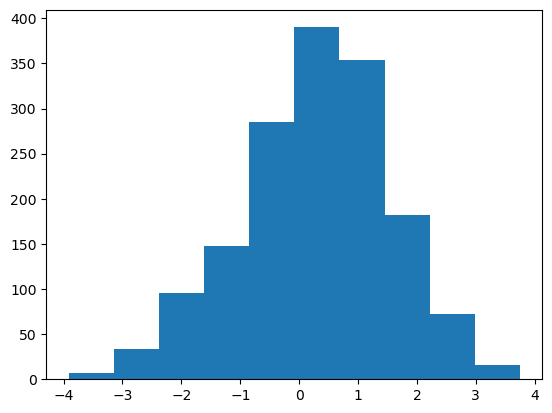

In [81]:
# Creating a model instance
adb = AdaBoostRegressor()
# Fitting the model on training data
adb.fit(X_train_scaled, y_train)

# Predicting on the test data
y_pred = adb.predict(X_test_scaled)

# Plotting the distribution of residuals
plt.figure()
residuals = y_test - y_pred
plt.hist(residuals)
plt.show()



In [82]:
# Printing the scores
print_scores(adb)



RMSE Train 1.2297
RMSE Test 1.2946
R2 Score Train 0.1964
R2 Score Test 0.1698


Let's perform hyperparameter tuning to see if the model performs better.



In [83]:
# Tuning the hyperparameters using RandomizedSearchCV
param_grid = {'n_estimators' : range(50, 200, 50), 'learning_rate' : np.linspace(0.05,0.2,4), "loss" : ['linear', 'square', 'exponential']}
rs = RandomizedSearchCV(AdaBoostRegressor(), param_grid, n_iter=200, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1, random_state=0)
rs.fit(X_train_scaled, y_train)



Fitting 5 folds for each of 36 candidates, totalling 180 fits


RandomizedSearchCV(cv=5, estimator=AdaBoostRegressor(), n_iter=200, n_jobs=-1,
                   param_distributions={'learning_rate': array([0.05, 0.1 , 0.15, 0.2 ]),
                                        'loss': ['linear', 'square',
                                                 'exponential'],
                                        'n_estimators': range(50, 200, 50)},
                   random_state=0, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [84]:
print("Best parameters are:", rs.best_params_)
print("Best score is", round(-rs.best_score_, 4))



Best parameters are: {'n_estimators': 100, 'loss': 'exponential', 'learning_rate': 0.05}
Best score is 1.1988


In [85]:
# Printing the scores after hyperparameter tuning
print_scores(rs)



RMSE Train 1.1858
RMSE Test 1.2447
R2 Score Train 0.2526
R2 Score Test 0.2326


The performance has improved.



In [86]:
# Assigning the best model from hyperparameter tuning
adb = rs.best_estimator_



### 6. Gradient Boosting Regressor

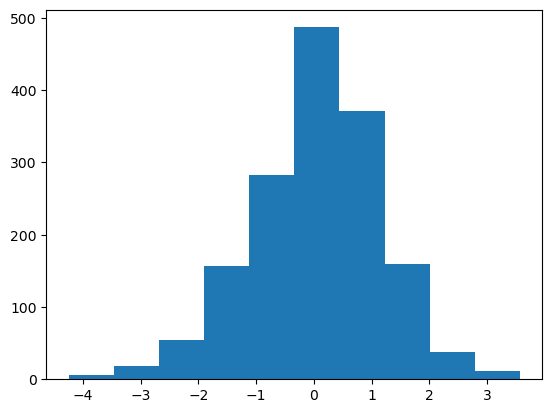

In [87]:
# Creating a model instance
gbr = GradientBoostingRegressor()
# Fitting the model on training data
gbr.fit(X_train_scaled, y_train)

# Predicting on the test data
y_pred = gbr.predict(X_test_scaled)

# Plotting the distribution of residuals
plt.figure()
residuals = y_test - y_pred
plt.hist(residuals)
plt.show()



In [88]:
# Printing the scores
print_scores(gbr)



RMSE Train 1.0221
RMSE Test 1.1064
R2 Score Train 0.4447
R2 Score Test 0.3937


Let's perform hyperparameter tuning to see if the model performs better.



In [89]:
# Tuning the hyperparameters using RandomizedSearchCV
param_grid = {'n_estimators' : range(100, 400, 100), 'learning_rate' : np.linspace(0.05,0.2,4), "subsample" : np.linspace(0.25,0.75,3),
              "criterion" : ['friedman_mse', 'squared_error'], 'min_samples_leaf' : range(1,10,2), 'max_depth': range(2,6),
              "min_samples_split" : range(2,5), 'max_features': ['sqrt', 'log2', None]}
rs = RandomizedSearchCV(GradientBoostingRegressor(), param_grid, n_iter=200, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1, random_state=1)
rs.fit(X_train_scaled, y_train)



Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_iter=200,
                   n_jobs=-1,
                   param_distributions={'criterion': ['friedman_mse',
                                                      'squared_error'],
                                        'learning_rate': array([0.05, 0.1 , 0.15, 0.2 ]),
                                        'max_depth': range(2, 6),
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': range(1, 10, 2),
                                        'min_samples_split': range(2, 5),
                                        'n_estimators': range(100, 400, 100),
                                        'subsample': array([0.25, 0.5 , 0.75])},
                   random_state=1, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [90]:
print("Best parameters are:", rs.best_params_)
print("Best score is", round(-rs.best_score_, 4))



Best parameters are: {'subsample': 0.75, 'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': None, 'max_depth': 5, 'learning_rate': 0.05, 'criterion': 'friedman_mse'}
Best score is 1.0624


In [91]:
# Printing the scores after hyperparameter tuning
print_scores(rs)



RMSE Train 0.8974
RMSE Test 1.0728
R2 Score Train 0.572
R2 Score Test 0.4299


The performance has improved.



In [92]:
# Assigning the best model from hyperparameter tuning
gbr = rs.best_estimator_



### 7. XGBoost Regressor

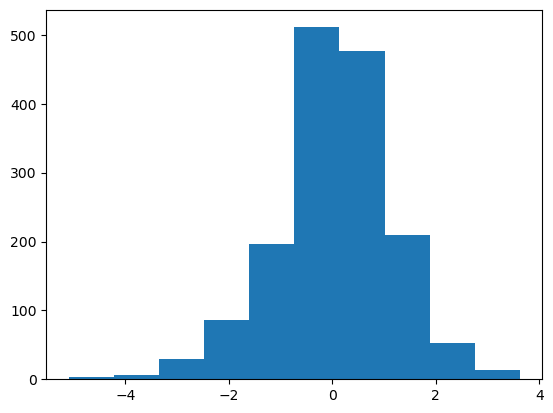

In [93]:
# Creating a model instance
xgbr = XGBRegressor()
# Fitting the model on training data
xgbr.fit(X_train_scaled, y_train)

# Predicting on the test data
y_pred = xgbr.predict(X_test_scaled)

# Plotting the distribution of residuals
plt.figure()
residuals = y_test - y_pred
plt.hist(residuals)
plt.show()



In [94]:
# Printing the scores
print_scores(xgbr)



RMSE Train 0.5509
RMSE Test 1.1224
R2 Score Train 0.8387
R2 Score Test 0.376


The model is overfitting.

Let's perform hyperparameter tuning to see if it performs better.

In [95]:
# Tuning the hyperparameters using RandomizedSearchCV
param_grid = {'colsample_bylevel' : np.linspace(0.25,0.75,3), 'colsample_bytree': np.linspace(0.25,0.75,3), 
              'learning_rate' : np.linspace(0.05,0.2,4), 'gamma' : np.linspace(0.001,0.01,4), 
              "max_depth" : range(2,6), "n_estimators" : range(100,400,100), 
              "subsample" : np.linspace(0.2,0.5,4)} #, 'reg_alpha': np.linspace(0,1,3), 'reg_lambda': np.linspace(0,1,3)}
rs = RandomizedSearchCV(XGBRegressor(), param_grid, n_iter=2000, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1, random_state=0)
rs.fit(X_train_scaled, y_train)



Fitting 5 folds for each of 2000 candidates, totalling 10000 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                   n_iter=2000, n_jobs=-1,
                   param_distributions={'colsample_bylevel': array([0.25, 0.5 , 0.75]),
                                        'colsample_bytree': array([0.25, 0.5 , 0.75]),
                                        'gamma': array([0.001, 0.004, 0.007, 0.01 ]),
                                        'learning_rate': array([0.05, 0.1 , 0.15, 0.2 ]),
                                        'max_depth': range(2, 6),
                                        'n_estimators': range(100, 400, 100),
                                        'subsample': array([0.2, 0.3, 0.4, 0.5])},
                   random_state=0, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [96]:
print("Best parameters are:", rs.best_params_)
print("Best score is", round(-rs.best_score_, 4))



Best parameters are: {'subsample': 0.4, 'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0.007000000000000001, 'colsample_bytree': 0.75, 'colsample_bylevel': 0.75}
Best score is 1.0604


In [97]:
# Printing the scores after hyperparameter tuning
print_scores(rs)



RMSE Train 0.9427
RMSE Test 1.0804
R2 Score Train 0.5277
R2 Score Test 0.4219


The performance has improved.



In [98]:
# Assigning the best model from hyperparameter tuning
xgbr = rs.best_estimator_



### 8. LightGBM Regressor

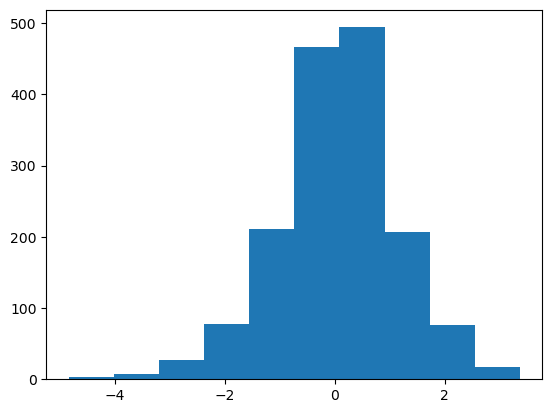

In [99]:
# Creating a model instance
lgbm = LGBMRegressor(verbose=-100)
# Fitting the model on training data
lgbm.fit(X_train_scaled, y_train)

# Predicting on the test data
y_pred = lgbm.predict(X_test_scaled)

# Plotting the distribution of residuals
plt.figure()
residuals = y_test - y_pred
plt.hist(residuals)
plt.show()



In [100]:
# Printing the scores
print_scores(lgbm)



RMSE Train 0.8438
RMSE Test 1.0906
R2 Score Train 0.6216
R2 Score Test 0.4108


The model is slightly overfitting.

Let's perform hyperparameter tuning to see if it performs better.

In [101]:
# Tuning the hyperparameters using RandomizedSearchCV
param_grid = {'num_leaves' : range(10, 100, 10), 'max_depth' : [-1,2,3,4], "learning_rate" : np.linspace(0.05,0.2,4),
              "n_estimators" : range(100,400,100), 'subsample': np.linspace(0.25,1,4),
              "min_child_samples" : range(10,50,10), 'colsample_bytree': np.linspace(0.25,0.75,3), 'reg_lambda': np.linspace(0,1,3)}
rs = RandomizedSearchCV(LGBMRegressor(verbose=-100), param_grid, n_iter=20, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1, random_state=0)
rs.fit(X_train_scaled, y_train)



Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=LGBMRegressor(verbose=-100), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': array([0.25, 0.5 , 0.75]),
                                        'learning_rate': array([0.05, 0.1 , 0.15, 0.2 ]),
                                        'max_depth': [-1, 2, 3, 4],
                                        'min_child_samples': range(10, 50, 10),
                                        'n_estimators': range(100, 400, 100),
                                        'num_leaves': range(10, 100, 10),
                                        'reg_lambda': array([0. , 0.5, 1. ]),
                                        'subsample': array([0.25, 0.5 , 0.75, 1.  ])},
                   random_state=0, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [102]:
print("Best parameters are:", rs.best_params_)
print("Best score is", round(-rs.best_score_, 4))



Best parameters are: {'subsample': 1.0, 'reg_lambda': 0.5, 'num_leaves': 50, 'n_estimators': 300, 'min_child_samples': 20, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.5}
Best score is 1.0625


In [103]:
# Printing the scores after hyperparameter tuning
print_scores(rs)



RMSE Train 0.8986
RMSE Test 1.0784
R2 Score Train 0.5709
R2 Score Test 0.4239


The performance has improved and the overfitting has reduced.



In [104]:
# Assigning the best model from hyperparameter tuning
lgbm = rs.best_estimator_



Let's compare all the models now.

### Comparing the models

In [105]:
# Creating a function that compares different models
def compare_models(models, model_names):
    model_df = pd.DataFrame()
    model_df.index = ['RMSE_Test', 'RMSE_Train', 'R2_Score_Test', 'R2_Score_Train']
    for model, model_name in zip(models, model_names):
        y_pred_test = model.predict(X_test_scaled)
        y_pred_train = model.predict(X_train_scaled)
        model_df[model_name] = [round(mean_squared_error(y_test, y_pred_test, squared=False), 2), 
                                round(mean_squared_error(y_train, y_pred_train, squared=False), 2),
                                round(r2_score(y_test, y_pred_test), 2), round(r2_score(y_train, y_pred_train), 2)]
    return model_df



In [106]:
# Comparing all the models 
models = [lr, knn, svr, rf, adb, gbr, xgbr, lgbm]
model_names = ['LinearRegression', 'KNN', 'SVR', 'RandomForest', 'AdaBoost', 'GradientBoosting', 'XGBoost', 'LightGBM']
compare_models(models, model_names)



,LinearRegression,KNN,SVR,RandomForest,AdaBoost,GradientBoosting,XGBoost,LightGBM
RMSE_Test,1.27,1.26,1.18,1.10,1.24,1.07,1.08,1.08
RMSE_Train,1.20,1.03,1.01,0.73,1.19,0.90,0.94,0.90
R2_Score_Test,0.21,0.22,0.31,0.40,0.23,0.43,0.42,0.42
R2_Score_Train,0.23,0.43,0.46,0.72,0.25,0.57,0.53,0.57


We can see that 3 models - Gradient Boosting, XGBoost, and LightGBM are performing adequately.

We can choose any one of them.

Let's choose XGBoost for now as it's showing the least amount of overfitting.



## Model Selection

In [107]:
# Creating a model instance with the tuned parameters.
model = XGBRegressor(**{'subsample': 0.4, 'n_estimators': 300, 'max_depth': 4, 
                        'learning_rate': 0.05, 'gamma': 0.007000000000000001, 
                        'colsample_bytree': 0.75, 'colsample_bylevel': 0.75})

# Fitting the model on training data
model.fit(X_train_scaled, y_train)




XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.75, colsample_bynode=None,
             colsample_bytree=0.75, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.007000000000000001, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [108]:
# Predicting on the test data
y_pred = model.predict(X_test_scaled)



In [109]:
# Printing the metrics
print("Mean Absolute Error", round(mean_absolute_error(y_test, y_pred), 2))
print("Mean Squared Error", round(mean_squared_error(y_test, y_pred), 2))
print("Root Mean Squared Error", round(mean_squared_error(y_test, y_pred, squared=False), 2))
print("R2 Score", round(r2_score(y_test, y_pred), 2))
      


Mean Absolute Error 0.83
Mean Squared Error 1.17
Root Mean Squared Error 1.08
R2 Score 0.42


In [111]:
# Predicting for a sample in test dataset
print("Predicted Rating: ", round(model.predict(X_test_scaled[0].reshape(1,-1))[0], 2))
print("Actual Rating: ", y_test.iloc[0])



Predicted Rating:  5.42
Actual Rating:  5.9


## Summary

Based on past movie data and features such as release year, duration, genre, number of votes, etc, we made a machine learning model that predicts the rating of a movie with a mean absolute error of 0.83.